In [590]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from math import gamma
from random import gauss

## Cholesky method 

In [3]:
def covFrac(s,t,H):
    return 0.5*(np.power(s,2.*H)+np.power(t,2.*H)-np.power(np.abs(t-s),2.*H))

In [362]:
def Cholesky(T,N,H):
    time_grid = np.linspace(0., T , N)[1:]
    covMatrixFrac = np.matrix([[covFrac(time_grid[i],time_grid[j],H) for j in np.arange(N-1)] for i in np.arange(N-1)])
    chol = np.linalg.cholesky(covMatrixFrac)
    gaussian = np.matrix(np.random.normal(0., 1., N-1))
    pathFBM = chol * gaussian.T
    return np.insert(time_grid,0,0), np.insert(pathFBM.A1,0,0)

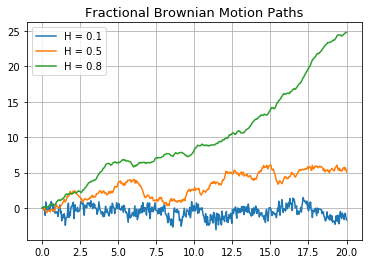

In [379]:
T = 20
N = 500
Hurst_Indices = [0.1, 0.5, 0.8]
for H in Hurst_Indices:
    plt.plot(Cholesky(T,N,H)[0], Cholesky(T,N,H)[1], label="H = %.1f" %H)
    plt.legend
    
plt.title("Fractional Brownian Motion Paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()

## Davies and Harte method

In [320]:
def autocovariance(k,H):
    return 0.5*(abs(k-1)**(2*H)-2*abs(k)**(2*H) + abs(k+1)**(2*H))

In [673]:
def DaviesHarte(T,N,H):
    row_comp = [autocovariance(k,H) for k in range(1,N)]
    reverse_comp = list(reversed(row_comp))
    first_row = [autocovariance(0,H)] + row_comp + [0] + reverse_comp
    eigenvalues = np.fft.fft(first_row).real
    if np.any([ev < 0 for ev in eigenvalues]):
            warnings.warn("Combination of increments n and Hurst value H "
                "invalid for Davies-Harte method. Reverting to Hosking method."
                " Occurs when n is small and Hurst is close to 1. ")
    V1 = np.random.normal(0.0,1.0,N)
    V2 = np.random.normal(0.0,1.0,N)
    w = np.zeros(2*N, dtype=complex)
    for i in range(2*N):
        if i == 0:
            w[i] = np.sqrt(eigenvalues[i] / (2 * N)) * V1[i]
        elif i < N:
            w[i] = np.sqrt(eigenvalues[i] / (4 * N)) * (V1[i] + 1j * V2[i])
        elif i == N:
            w[i] = np.sqrt(eigenvalues[i] / (2 * N)) * V2[0]
        else:
            w[i] = np.sqrt(eigenvalues[i] / (4 * N)) * (V1[2 * N - i] - 1j * V2[2 * N - i])
    Z = np.fft.fft(w).real
    fGN = Z[:N]
    scale = (1.0*T/N)**H
    time_scaled_fGN = scale * fGN
    pathFBM = np.insert(time_scaled_fGN.cumsum(), [0], 0)
    time_grid = np.linspace(0, T, N+1)
    return np.insert(time_grid,0,0), np.insert(pathFBM,0,0)

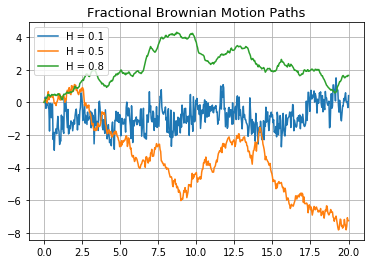

In [674]:
T = 20
N = 2**9
Hurst_Indices = [0.1, 0.5, 0.8]
for H in Hurst_Indices:
    plt.plot(DaviesHarte(T,N,H)[0], DaviesHarte(T,N,H)[1], label="H = %.1f" %H)
    plt.legend
    
plt.title("Fractional Brownian Motion Paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()

## Riemann-sum approximation

In [582]:
def Riemann(T,N,H):
    b = int(N**(3./2.))
    time_grid = np.linspace(0.0,T,N)
    B1 = np.random.normal(0.0,1.0,b+1)
    B2 = np.random.normal(0.0,1.0,N+1)
    pathFBM = []
    for n in np.arange(N):
        first_int_grid = np.arange(-b,0.0)
        C_H = np.sqrt(np.sum([((1.0-k)**(H-0.5)-(-k)**(H-0.5))**2.0 for k in first_int_grid]) + 1.0/(2.*H))
        first_int = np.sum([((n-first_int_grid[k])**(H-0.5)-(-first_int_grid[k])**(H-0.5))*B1[k] for k in np.arange(len(first_int_grid))])
        sec_int = np.sum([(n-k)**(H-0.5)*B2[k] for k in np.arange(n)])
        scale = (1.0*T/N)**H
        pathFBM.append(scale*(1.0/C_H*(first_int + sec_int)))
    return np.insert(time_grid,0,0), np.insert(pathFBM,0,0)

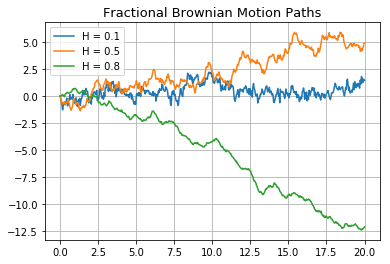

In [555]:
T = 20
N = 500
Hurst_Indices = [0.1, 0.5, 0.8]
for H in Hurst_Indices:
    plt.plot(Riemann(T,N,H)[0], Riemann(T,N,H)[1], label="H = %.1f" %H)
    plt.legend
    
plt.title("Fractional Brownian Motion Paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()

## Spectral simulation

In [576]:
def spectral_density(lamb, H):
    B = np.sum([(2.*np.pi*j+lamb)**(-2.*H-1.) + (2.*np.pi*j-lamb)**(-2.*H-1.) for j in np.arange(1,1000)])
    return 2.*np.sin(np.pi*H)*gamma(2.*H+1.)*(1.-np.cos(lamb))*(np.abs(lamb)**(-2.*H-1.) + B)

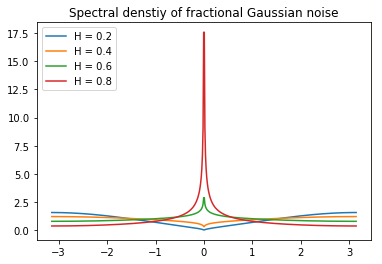

In [589]:
Hurst = [0.2,0.4,0.6,0.8]
for H in Hurst:
    grid = np.linspace(-np.pi,np.pi,500)
    plt.plot(grid,[spectral_density(k,H) for k in grid], label="H = %.1f" %H)
plt.legend(loc=2)
plt.title('Spectral denstiy of fractional Gaussian noise')
plt.show()

In [578]:
def Spectral(T,N,H):
    l = int(N/2)
    t = [np.pi*k/l for k in np.arange(l+1)] 
    U0 = np.random.normal(0.0,1.0,l)
    U1 = np.random.normal(0.0,1.0,l)
    a = np.zeros(2*l, dtype=complex)
    for i in range(2*l):
        if i == 0:
            a[i] = 0.0
        elif i < l:
            a[i] = 0.5*(U0[i-1] + 1j*U1[i-1])*np.sqrt(spectral_density(t[i],H)/l)
        elif i == l:
            a[i] = U0[i-1]*np.sqrt(spectral_density(t[i],H)/l)
        else:
            a[i] = 0.5*(U0[2*l-i-1] - 1j*U1[2*l-i-1])*np.sqrt(spectral_density(t[2*l-i],H)/l)
    fGN = np.fft.fft(a).real
    scale = (1.0*T/N)**H
    time_scaled_fGN = scale * fGN
    pathFBM = np.insert(time_scaled_fGN.cumsum(), [0], 0)
    time_grid = np.linspace(0, T, N+1)
    return np.insert(time_grid,0,0), np.insert(pathFBM,0,0)

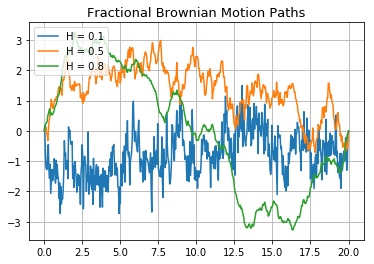

In [586]:
T = 20
N = 2**9
Hurst_Indices = [0.1, 0.5, 0.8]
for H in Hurst_Indices:
    plt.plot(Spectral(T,N,H)[0], Spectral(T,N,H)[1], label="H = %.1f" %H)
    plt.legend
    
plt.title("Fractional Brownian Motion Paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()

## Paxson method

In [592]:
def spectral_density(lamb, H):
    B = np.sum([(2.*np.pi*j+lamb)**(-2.*H-1.) + (2.*np.pi*j-lamb)**(-2.*H-1.) for j in np.arange(1,1000)])
    return 2.*np.sin(np.pi*H)*gamma(2.*H+1.)*(1.-np.cos(lamb))*(np.abs(lamb)**(-2.*H-1.) + B)

In [594]:
def Payson(T,N,H):
    t = [1*np.pi*k/N for k in np.arange(N)] 
    R = np.random.exponential(1.0,N/2)
    Phi = np.random.uniform(0.0,2*np.pi,N/2-1)
    Phi.append(0.0)
    b = np.zeros(N, dtype=complex)
    for i in range(2*l):
        if i == 0:
            b[i] = 0.0
        elif i < N/2+1:
            b[i] = np.sqrt(R[i-1]*spectral_density(t[i],H)/N)*np.exp(1j*Phi[i-11])
        else:
            b[i] = np.conj(b[N-i])
    fGN = np.fft.fft(b).real
    scale = (1.0*T/N)**H
    time_scaled_fGN = scale * fGN
    pathFBM = np.insert(time_scaled_fGN.cumsum(), [0], 0)
    time_grid = np.linspace(0, T, N+1)
    return np.insert(time_grid,0,0), np.insert(pathFBM,0,0)

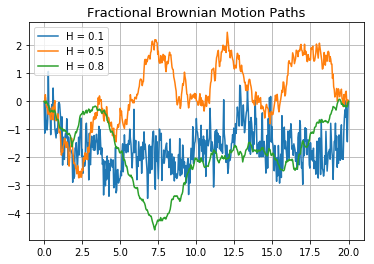

In [595]:
T = 20
N = 2**9
Hurst_Indices = [0.1, 0.5, 0.8]
for H in Hurst_Indices:
    plt.plot(Spectral(T,N,H)[0], Spectral(T,N,H)[1], label="H = %.1f" %H)
    plt.legend
    
plt.title("Fractional Brownian Motion Paths", fontsize=13)
plt.legend(loc=2)
plt.grid(True)
plt.show()